In [1]:
import re, os, sys
import pandas as pd
import math
import matplotlib.pyplot as plt

## Helper Functions

In [2]:
def readFasta(file):
    if not os.path.exists(file):
        print('Error: "' + file + '" does not exist.')
        sys.exit(1)

    with open(file) as f:
        records = f.read()

    if '>' not in records:
        print('The input file seems not in fasta format.')
        sys.exit(1)

    records = records.split('>')[1:]
    myFasta = []
    for fasta in records:
        array = fasta.split('\n')
        name = array[0].split()[0]
        # keep only canonical 20 amino acids
        seq_raw = ''.join(array[1:]).upper()
        sequence = re.sub('[^ARNDCQEGHILKMFPSTWYV]', '', seq_raw)
        myFasta.append([name, sequence])
    return myFasta

def infer_label(name):
    h = name.lower()
    if h.startswith("ap"):
        return 1
    if h.startswith("neg"):
        return 0
    raise ValueError(f"Could not infer label from header: {name}")

def load_split(path, split):
    records = readFasta(path)
    rows = []
    for name, seq in records:
        if not seq:   # skip empty after cleaning
            continue
        label = infer_label(name)
        rows.append({
            "id": name,
            "label": label,
            "split": split,
            "seq": seq,
        })
    return pd.DataFrame(rows)

## Parse to a DF

In [3]:
train_df = load_split("data/train_MRSA.fasta", split="train")
test_df  = load_split("data/test_MRSA.fasta", split="test")

df = pd.concat([train_df, test_df], ignore_index=True)
print(df.head())
print(df["label"].value_counts(), "\n", df.groupby("split")["label"].value_counts())

        id  label  split                             seq
0  AP00150      1  train                   ILPWKWPWWPWRR
1  AP00155      1  train   RGLRRLGRKIAHGVKKYGPTVLRIIRIAG
2  AP00166      1  train       GWGSFFKKAAHVGKHVGKAALTHYL
3  AP00176      1  train  ACYCRIPACIAGERRYGTCIYQGRLWAFCC
4  AP00195      1  train              RGGRLCYCRRRFCVCVGR
label
0    847
1    148
Name: count, dtype: int64 
 split  label
test   0        169
       1         30
train  0        678
       1        118
Name: count, dtype: int64


In [4]:
# length stats
df["length"] = df["seq"].str.len()
print(df.groupby("label")["length"].describe())

       count       mean        std   min   25%   50%   75%   max
label                                                           
0      847.0  30.977568  11.492138  11.0  21.0  31.0  41.0  50.0
1      148.0  26.439189  11.367830  11.0  19.0  24.0  33.0  70.0


## Compute Physicochmeical Properties

In [5]:
KD = { # Kyte–Doolittle
 'I':4.5,'V':4.2,'L':3.8,'F':2.8,'C':2.5,'M':1.9,'A':1.8,'G':-0.4,'T':-0.7,'S':-0.8,
 'W':-0.9,'Y':-1.3,'P':-1.6,'H':-3.2,'E':-3.5,'Q':-3.5,'D':-3.5,'N':-3.5,'K':-3.9,'R':-4.5}

def net_charge_pH74(seq):
    pos = seq.count('K') + seq.count('R') + 0.1*seq.count('H')
    neg = seq.count('D') + seq.count('E')
    return pos - neg

def kd_mean(seq):
    return sum(KD[a] for a in seq) / len(seq)

def hydrophobic_moment_alpha(seq):
    theta = math.radians(100.0)
    vx = vy = 0.0
    for i, a in enumerate(seq):
        h = KD.get(a, 0.0)
        angle = i * theta
        vx += h * math.cos(angle)
        vy += h * math.sin(angle)
    return (vx**2 + vy**2) ** 0.5 / len(seq)

def aromatic_frac(seq):
    arom = sum(seq.count(a) for a in "FWY")
    return arom / len(seq)

df["net_charge_pH7.4"] = df["seq"].map(net_charge_pH74)
df["kd_mean"] = df["seq"].map(kd_mean)
df["hydrophobic_moment"] = df["seq"].map(hydrophobic_moment_alpha)
df["aromatic_frac"] = df["seq"].map(aromatic_frac)

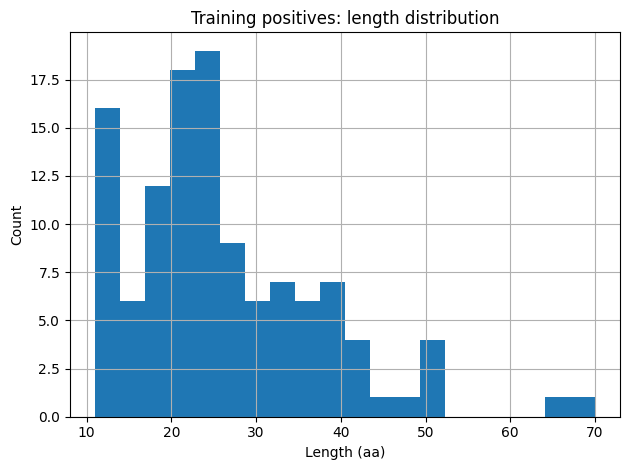

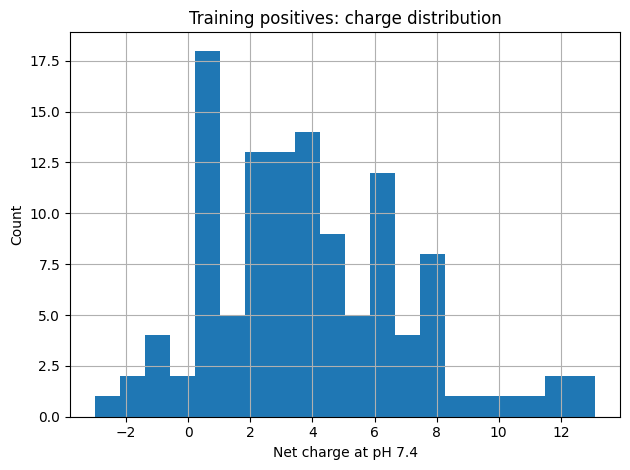

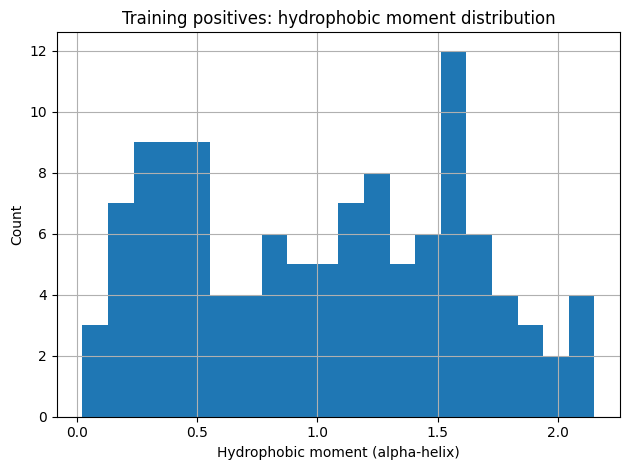

In [6]:
# Plot distributions for training positives only
pos_train = df[(df["split"] == "train") & (df["label"] == 1)]

# Length histogram
plt.figure()
pos_train["length"].hist(bins=20)
plt.xlabel("Length (aa)")
plt.ylabel("Count")
plt.title("Training positives: length distribution")
plt.tight_layout()
plt.savefig("train_pos_length_hist.png")
plt.show()

# Charge distribution
plt.figure()
pos_train["net_charge_pH7.4"].hist(bins=20)
plt.xlabel("Net charge at pH 7.4")
plt.ylabel("Count")
plt.title("Training positives: charge distribution")
plt.tight_layout()
plt.savefig("train_pos_charge_hist.png")
plt.show()

# Hydrophobic moment distribution
plt.figure()
pos_train["hydrophobic_moment"].hist(bins=20)
plt.xlabel("Hydrophobic moment (alpha-helix)")
plt.ylabel("Count")
plt.title("Training positives: hydrophobic moment distribution")
plt.tight_layout()
plt.savefig("train_pos_hmoment_hist.png")
plt.show()

## Adding Secondary Structure Information
# Export positive training sequences to a FASTA file for secondary structure prediction
with open("train_pos_for_ss.fasta", "w") as f:
    for _, row in pos_train.iterrows():
        f.write(f">{row['id']}\n{row['seq']}\n")

## Adding Secondary Structure Information

In [9]:
# Export positive training sequences to a FASTA file for secondary structure prediction
pos_train = df[(df["split"] == "train") & (df["label"] == 1)]

with open("Data/train_pos_for_ss.fasta", "w") as f:
    for _, row in pos_train.iterrows():
        f.write(f">{row['id']}\n{row['seq']}\n")

pos_test = df[(df["split"] == "test") & (df["label"] == 1)]

with open("Data/test_pos_for_ss.fasta", "w") as f:
    for _, row in pos_test.iterrows():
        f.write(f">{row['id']}\n{row['seq']}\n")

In [8]:
# STEP 3C: parse NetSurfP CSV and merge secondary structure into df
# After running NetSurfP on 'train_pos_for_ss.fasta',
# save the table as 'train_pos_ss.csv' (it is tab-separated).
try:
    ss_df = pd.read_csv("train_pos_for_ss.csv", sep=",")
    ss_df.columns = ss_df.columns.str.strip()
except FileNotFoundError:
    print("Warning: 'train_pos_for_ss.csv' not found. Run NetSurfP and save its output with that name.")
    ss_df = None

# Your columns: id, seq, n, rsa, asa, q3, ..., q8, ...
# Clean id to match df['id'] (remove leading '>')
ss_df["clean_id"] = ss_df["id"].astype(str).str.lstrip(">")

# We only need q3 (H/E/C)
# Count residues per (clean_id, q3)
counts = (
    ss_df
    .groupby(["clean_id", "q3"])
    .size()
    .unstack(fill_value=0)
)

# Ensure columns exist for all H/E/C
for col in ["H", "E", "C"]:
    if col not in counts.columns:
        counts[col] = 0

# Fractions
counts = counts.div(counts.sum(axis=1), axis=0)

ss_summary = counts.rename(columns={
    "H": "frac_helix",
    "E": "frac_sheet",
    "C": "frac_coil"
})

# Merge into main df on id
df = df.merge(ss_summary, left_on="id", right_index=True, how="left")

print(df[["id", "split", "label", "frac_helix", "frac_sheet", "frac_coil"]].head())

        id  split  label  frac_helix  frac_sheet  frac_coil
0  AP00150  train      1    0.000000    0.000000   1.000000
1  AP00155  train      1    0.206897    0.000000   0.793103
2  AP00166  train      1    0.000000    0.000000   1.000000
3  AP00176  train      1    0.000000    0.300000   0.700000
4  AP00195  train      1    0.000000    0.333333   0.666667


In [9]:
# STEP 4: define SS-based categories for conditioning
def helix_category(frac_h):
    if pd.isna(frac_h):
        return "ss_unknown"
    if frac_h >= 0.40:
        return "helix_high"
    if frac_h >= 0.20:
        return "helix_med"
    return "helix_low"

df["ss_label"] = df["frac_helix"].map(helix_category)

# For ProGen2 conditioning, we care about training positives:
pos_train = df[(df["split"] == "train") & (df["label"] == 1)].copy()
pos_train["cond_tag"] = pos_train["ss_label"] + " anti-MRSA peptide"

In [10]:
# STEP 5: write prefix-tuning / prompt-training dataset
# One sample per line: "<cond_tag>: <sequence>"
with open("progen2_prefix_train.txt", "w") as f:
    for _, row in pos_train.iterrows():
        f.write(f"{row['cond_tag']}: {row['seq']}\n")

print("Wrote prefix-tuning data to 'progen2_prefix_train.txt'")

Wrote prefix-tuning data to 'progen2_prefix_train.txt'
